In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Import scoring metrics
from sklearn.metrics import mean_squared_error, r2_score

pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', '{:.5f}'.format) # suppress scientific notation

# Can we predict holiday rental prices? 

In [3]:
list_df = pd.read_csv('./Data/listings.csv')
print(list_df.shape)


(6536, 74)


In [4]:
list_df['price'] = list_df['price'].replace('[\$,]', '', regex=True).astype(float)

In [5]:
def process_bathrooms_text(string):
    try:
        return float((re.findall(r'\d+(?:\.\d+)?', string))[0])
    except:
        return 0


In [6]:
list_df['num_bathrooms'] = list_df['bathrooms_text'].apply(process_bathrooms_text)
list_df['shared_bathroom'] = list_df['bathrooms_text'].str.contains('shared')
list_df['shared_bathroom'] = list_df['shared_bathroom'].replace({ True: 1, False: 0})
list_df.shape

(6536, 76)

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'scrape_id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>,
        <AxesSubplot:title={'center':'neighbourhood_group_cleansed'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>],
       [<AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'minimum_minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_minimum_nights'}>,
        <AxesSubplot:title={'center':'minimum_maxi

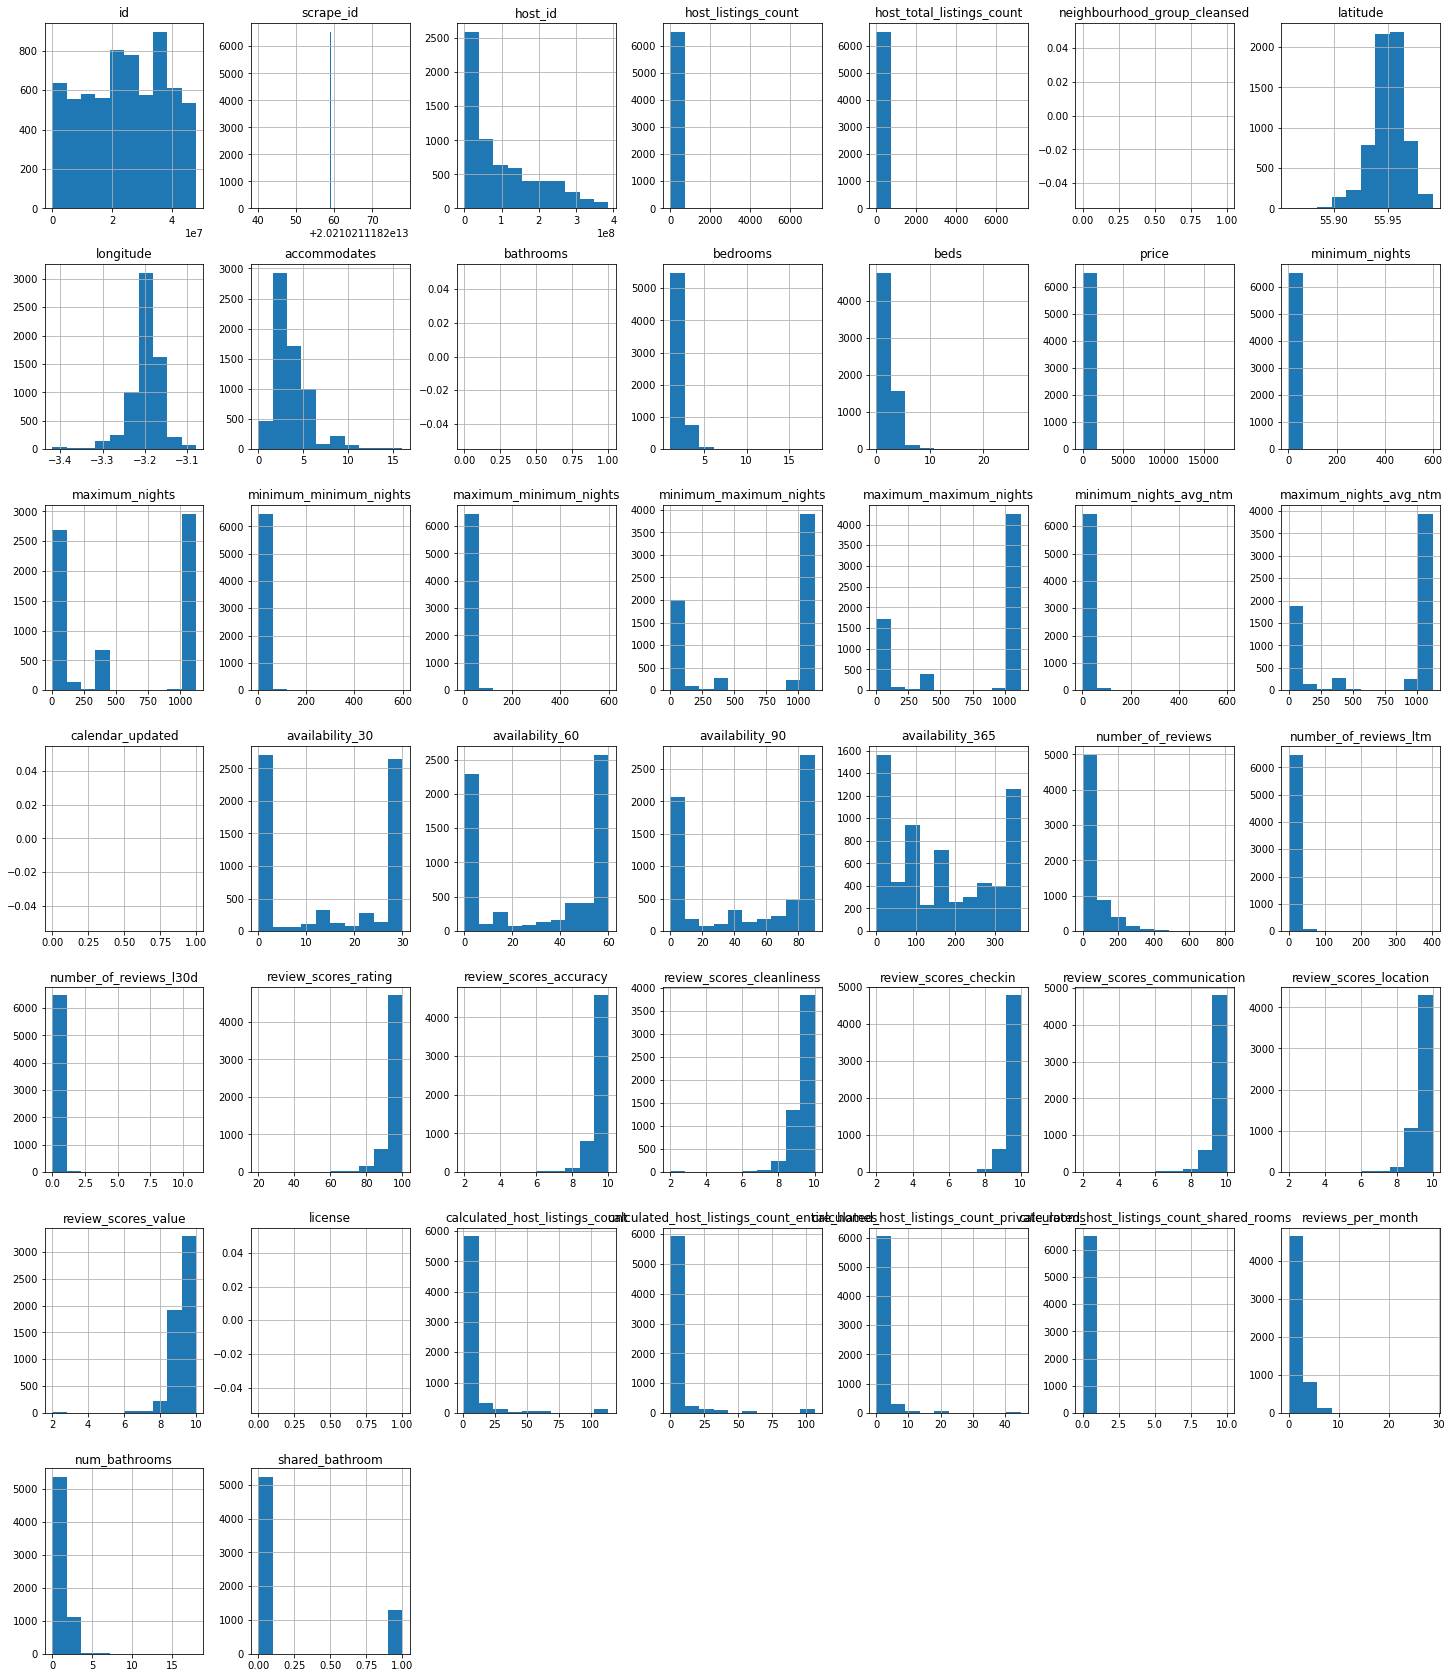

In [7]:
# Plot distributions...
list_df.hist(figsize = (25,30))

In [8]:
# find columns that are only NaN
print( (list_df.isnull().sum() / len(list_df) * 100).sort_values(ascending=False))


bathrooms                                      100.00000
neighbourhood_group_cleansed                   100.00000
license                                        100.00000
calendar_updated                               100.00000
host_neighbourhood                              44.23195
host_response_time                              40.80477
host_response_rate                              40.80477
host_about                                      40.29988
neighborhood_overview                           25.36720
neighbourhood                                   25.36720
host_acceptance_rate                            21.66463
review_scores_checkin                           15.48348
review_scores_location                          15.48348
review_scores_value                             15.48348
review_scores_communication                     15.46818
review_scores_accuracy                          15.46818
review_scores_cleanliness                       15.46818
review_scores_rating           

In [9]:
drop_cols = ["id", "listing_url", "scrape_id", "last_scraped", "picture_url","latitude", "longitude", 
             "host_is_superhost", "host_response_time", "neighbourhood", "host_identity_verified", 
             'has_availability', 'instant_bookable', 'host_response_rate', 
             'host_acceptance_rate','minimum_maximum_nights',# irrelevant
             "host_verifications", "calendar_last_scraped", "first_review", "last_review", 
             "bathrooms", "license", "neighbourhood_group_cleansed", "calendar_updated", # missing data
             "host_id", "host_url", "host_name", "host_since", "host_location", "host_about", 
             "host_has_profile_pic", "host_thumbnail_url", "host_picture_url", 
             "host_neighbourhood", # personal information
             "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
             "review_scores_checkin", "review_scores_communication", "review_scores_location", 
             "review_scores_value", "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d", 
             "reviews_per_month", # data leakage, cannot be known in advance
             "host_listings_count", "host_total_listings_count", 
             "minimum_nights", "minimum_minimum_nights", "maximum_minimum_nights", 
             "minimum_nights_avg_ntm", "calculated_host_listings_count_shared_rooms", #  seem to have mostly one value
             "maximum_nights_avg_ntm", "availability_90", "availability_60", 
             "calculated_host_listings_count_entire_homes", 
             "maximum_maximum_nights", "beds", # strong correlation with other features
             "description", "neighborhood_overview", "name" # free text suitable for different approach, 
             
            ]

In [10]:
list_df.drop(columns=drop_cols,inplace=True)

In [11]:
#list_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [12]:
list_df.columns

Index(['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'amenities', 'price', 'maximum_nights',
       'availability_30', 'availability_365', 'calculated_host_listings_count',
       'calculated_host_listings_count_private_rooms', 'num_bathrooms',
       'shared_bathroom'],
      dtype='object')

array([[<AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_365'}>],
       [<AxesSubplot:title={'center':'calculated_host_listings_count'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count_private_rooms'}>,
        <AxesSubplot:title={'center':'num_bathrooms'}>],
       [<AxesSubplot:title={'center':'shared_bathroom'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

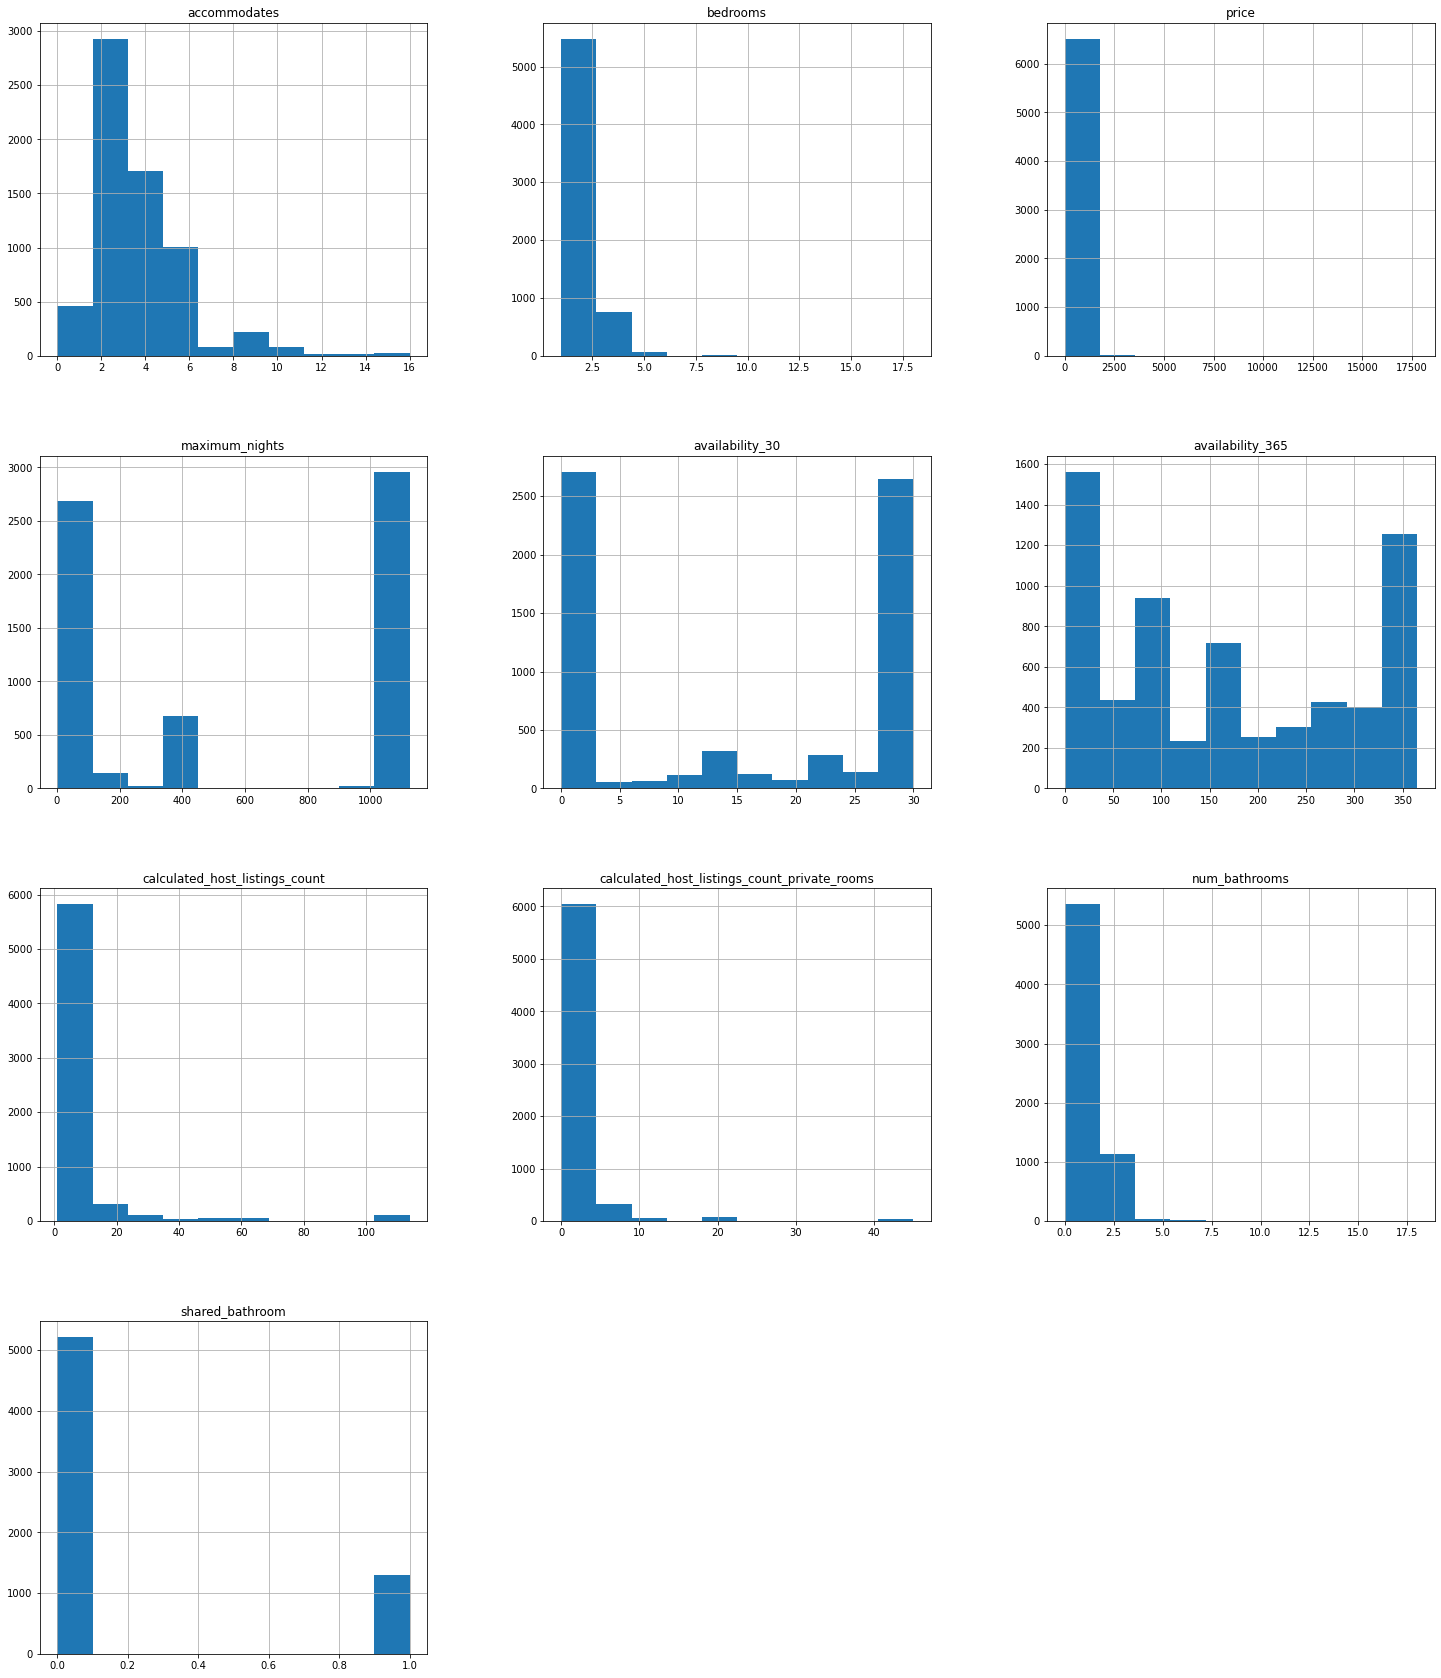

In [13]:
# Plot distributions...
list_df.hist(figsize = (25,30))


In [14]:
list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   neighbourhood_cleansed                        6536 non-null   object 
 1   property_type                                 6536 non-null   object 
 2   room_type                                     6536 non-null   object 
 3   accommodates                                  6536 non-null   int64  
 4   bathrooms_text                                6523 non-null   object 
 5   bedrooms                                      6328 non-null   float64
 6   amenities                                     6536 non-null   object 
 7   price                                         6536 non-null   float64
 8   maximum_nights                                6536 non-null   int64  
 9   availability_30                               6536 non-null   i

C:\Users\Katya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Katya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Katya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Katya\anaconda3\lib\si

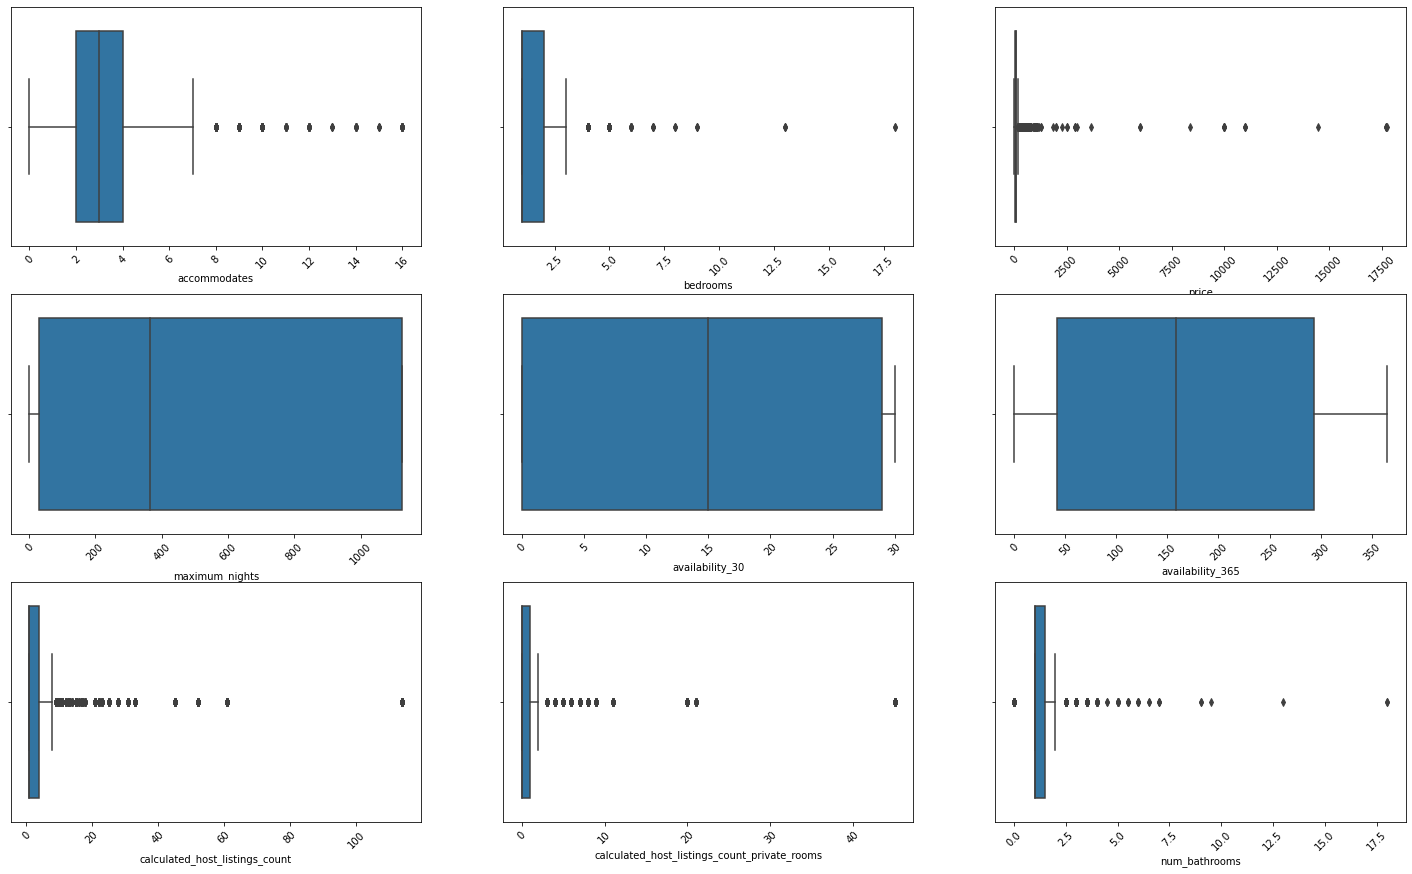

In [15]:
fig1, ax = plt.subplots(3, 3, figsize=(25,15))
for variable, subplot in zip(list_df.select_dtypes(include=['int64','float64']), ax.flatten()):
    sns.boxplot(list_df[variable], ax=subplot )
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

In [16]:
#Drop outliers (3 standard deviations from the mean)

for col in list_df.select_dtypes(include=['int64','float64']):
    list_df = list_df[np.abs(list_df[col] - list_df[col].mean()) 
                    <= (3 * list_df[col].std())]


In [17]:
list_df[['price','accommodates', 'bedrooms', 'availability_365']].describe()

,price,accommodates,bedrooms,availability_365
count,5724.00000,5724.00000,5724.00000,5724.00000
mean,94.12404,3.26398,1.46366,160.37753
std,113.81553,1.59558,0.64642,130.69020
min,8.00000,1.00000,1.00000,0.00000
25%,45.00000,2.00000,1.00000,41.00000
50%,68.00000,3.00000,1.00000,146.00000
75%,100.00000,4.00000,2.00000,281.00000
max,1280.00000,9.00000,3.00000,365.00000


In [18]:
corr_features = list_df.select_dtypes(include=['float64', 'int64'])
corr_features

,accommodates,bedrooms,price,maximum_nights,availability_30,availability_365,calculated_host_listings_count,calculated_host_listings_count_private_rooms,num_bathrooms,shared_bathroom
0,2,1.00000,70.00000,30,15,310,1,0,1.00000,0.00000
1,2,1.00000,45.00000,120,29,356,2,0,1.50000,0.00000
2,2,1.00000,45.00000,10,30,90,1,1,2.50000,1.00000
3,2,1.00000,31.00000,21,29,89,2,2,1.00000,1.00000
4,6,3.00000,164.00000,28,20,301,1,0,1.50000,0.00000
...,...,...,...,...,...,...,...,...,...,...
6530,4,1.00000,81.00000,31,0,0,3,0,1.00000,0.00000
6532,8,3.00000,90.00000,14,0,0,1,0,1.50000,0.00000
6533,4,2.00000,40.00000,66,0,97,2,1,2.00000,0.00000
6534,6,3.00000,200.00000,1125,14,349,17,0,2.00000,0.00000


In [19]:
correlations = list_df[list(corr_features)].corr()
# examine the correlations 
sol = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False).to_frame().reset_index()
sol.columns=['Feature 1', 'Feature 2', 'Correlation']
sol

,Feature 1,Feature 2,Correlation
0,accommodates,bedrooms,0.79037
1,availability_30,availability_365,0.56661
2,bedrooms,num_bathrooms,0.38592
3,calculated_host_listings_count_private_rooms,shared_bathroom,0.34244
4,accommodates,num_bathrooms,0.32883
5,bedrooms,price,0.23556
6,accommodates,price,0.22618
7,price,num_bathrooms,0.16612
8,calculated_host_listings_count,calculated_host_listings_count_private_rooms,0.16055
9,price,calculated_host_listings_count,0.14004


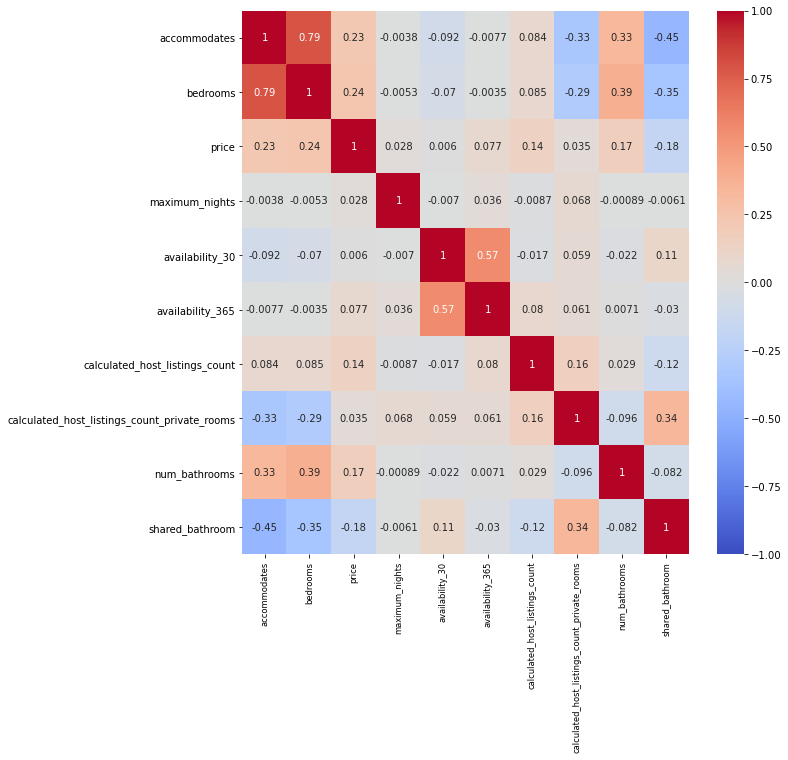

In [20]:
plt.figure(figsize=(10,10))
#Plot heatmap of correlations
fig = sns.heatmap(correlations,vmin=-1,
            cmap='coolwarm',
            annot=True
               )

fig.set_xticklabels(fig.get_xticklabels(), rotation=90,fontsize='small')
plt.show()

In [21]:
# list_df[['host_response_rate','host_acceptance_rate']] = list_df[['host_response_rate','host_acceptance_rate']].replace('%', '', regex=True).astype(float)
# list_df[['host_response_rate','host_acceptance_rate']] = list_df[['host_response_rate','host_acceptance_rate']] / 100
   

In [22]:
def split_amenities(string_of_amenities):
    pattern = re.compile(r'\\u2019|\\u2013|\\u2014|\\u00a32|\\u00a33|\\u00a0|\["|"\]|\[\]|\\')
    string_of_amenities = re.sub(pattern, '', string_of_amenities)
    return string_of_amenities.split('", "')

In [23]:
list_df['amenities'] = list_df['amenities'].apply(split_amenities)

In [24]:
def process_amenities(list_of_amenities):
    result = list()
    for amenity in list_of_amenities:
        if 'wifi' in amenity.lower():
            result.append('wifi')
        elif 'washer' in amenity.lower():
            result.append('washer')
        elif 'breakfast' in amenity.lower():
            result.append('breakfast')
        elif 'tv' in amenity.lower():
            result.append('tv')
        elif 'free parking' in amenity.lower() or 'free street parking' in amenity.lower() \
            or 'free carport' in amenity.lower() or 'free driveway' in amenity.lower() \
            or 'free residential garage' in amenity.lower():
            result.append('free parking')
        elif 'paid parking' in amenity.lower() or 'paid street parking' in amenity.lower():
            result.append('paid parking')
        elif 'clothing storage' in amenity.lower():
            result.append('clothing storage')
        elif 'body soap' in amenity.lower() or 'conditioner' in amenity.lower() \
            or 'toiletries' in amenity.lower() or 'shower gel' in amenity.lower() \
            or 'shampoo' in amenity.lower():
            result.append('toiletries')
        elif 'sound system' in amenity.lower():
            result.append('sound system')
        elif 'game console' in amenity.lower():
            result.append('game console')
        elif 'baby' in amenity.lower() or 'children' in amenity.lower() \
            or 'crib' in amenity.lower() or 'changing table' in amenity.lower() \
            or 'high chair' in amenity.lower():
            result.append('baby/child amenities')
        elif 'bed linen' in amenity.lower() or 'bed sheet' in amenity.lower():
            result.append('bed linen')
        elif 'oven' in amenity.lower() or 'stove' in amenity.lower():
            result.append('oven or stove')
        elif 'refrigerator' in amenity.lower() or 'fridge' in amenity.lower():
            result.append('fridge')
        elif 'dedicated workspace' in amenity.lower():
            result.append('dedicated workspace')
        elif 'dryer' in amenity.lower():
            result.append('dryer')
        elif 'gym' in amenity.lower() or 'fitness' in amenity.lower():
            result.append('gym')
        elif 'nespresso' in amenity.lower() or 'coffee' in amenity.lower():
            result.append('coffee facilities')
        else:
            result.append(amenity.lower())
    return result
        

In [25]:
list_df['amenities'] = list_df['amenities'].apply(process_amenities)

In [26]:
amenities = set([ amen for amen_lst in list_df['amenities'].tolist() for amen in amen_lst ]) 

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
#Encode the multilabel data in MLB Format
amenities_bin_df = pd.DataFrame(mlb.fit_transform(list_df['amenities']), columns=mlb.classes_)
#amenities_bin_df.sum()     

In [28]:
# drop least common amenities, along with original column 'amenities'
drop_amenities = [  ]

for col in amenities_bin_df.columns:
    print(col, amenities_bin_df[col].sum(),amenities_bin_df[col].sum() / len(list_df) )
    if (amenities_bin_df[col].sum() / len(list_df) < 0.18):
         drop_amenities.append(col)
#print(drop_amenities)            

 1 0.00017470300489168413
air conditioning 134 0.023410202655485674
baby/child amenities 1181 0.20632424877707897
baking sheet 168 0.029350104821802937
barbecue utensils 32 0.005590496156533892
bathroom essentials 109 0.019042627533193572
bathtub 741 0.12945492662473795
bbq grill 99 0.01729559748427673
beach essentials 13 0.0022711390635918936
beachfront 50 0.008735150244584208
bed linen 2957 0.51659678546471
bedroom comforts 109 0.019042627533193572
bikes 2 0.00034940600978336826
board games 9 0.0015723270440251573
bread maker 13 0.0022711390635918936
breakfast 985 0.17208245981830889
building staff 51 0.00890985324947589
carbon monoxide alarm 4524 0.790356394129979
ceiling fan 8 0.001397624039133473
central heating 37 0.006464011180992313
cleaning before checkout 129 0.022536687631027254
cleaning products 42 0.007337526205450734
clothing storage 35 0.006114605171208945
coffee facilities 1810 0.3162124388539483
cooking basics 3037 0.5305730258560447
dedicated workspace 3834 0.66981132

In [29]:
amenities_bin_df.drop(columns=drop_amenities,inplace=True)

In [30]:
list_df = pd.concat([list_df, amenities_bin_df], axis=1, ignore_index=False)

In [31]:
dummies_df = pd.get_dummies(list_df[[
                                     'neighbourhood_cleansed', 
                                     'room_type', 
                                     'property_type' 
                                    ]])

In [32]:
list_final_df = pd.concat([list_df, dummies_df], axis=1, ignore_index=False)
list_final_df.drop(columns=['amenities',
                            'neighbourhood_cleansed', 
                            'room_type', 
                            'property_type', 
                            'bathrooms_text',
                            ],inplace=True)

#list_final_df = list_final_df.reset_index()

display(list_final_df.shape)


(6335, 206)

In [33]:
list_final_df


,accommodates,bedrooms,price,maximum_nights,availability_30,availability_365,calculated_host_listings_count,calculated_host_listings_count_private_rooms,num_bathrooms,shared_bathroom,...,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room in apartment,property_type_Shared room in condominium,property_type_Shared room in hostel,property_type_Shared room in house,property_type_Tiny house,property_type_Windmill
0,2.00000,1.00000,70.00000,30.00000,15.00000,310.00000,1.00000,0.00000,1.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
1,2.00000,1.00000,45.00000,120.00000,29.00000,356.00000,2.00000,0.00000,1.50000,0.00000,...,0,0,0,0,0,0,0,0,0,0
2,2.00000,1.00000,45.00000,10.00000,30.00000,90.00000,1.00000,1.00000,2.50000,1.00000,...,0,0,0,0,0,0,0,0,0,0
3,2.00000,1.00000,31.00000,21.00000,29.00000,89.00000,2.00000,2.00000,1.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0
4,6.00000,3.00000,164.00000,28.00000,20.00000,301.00000,1.00000,0.00000,1.50000,0.00000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6530,4.00000,1.00000,81.00000,31.00000,0.00000,0.00000,3.00000,0.00000,1.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
6532,8.00000,3.00000,90.00000,14.00000,0.00000,0.00000,1.00000,0.00000,1.50000,0.00000,...,0,0,0,0,0,0,0,0,0,0
6533,4.00000,2.00000,40.00000,66.00000,0.00000,97.00000,2.00000,1.00000,2.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
6534,6.00000,3.00000,200.00000,1125.00000,14.00000,349.00000,17.00000,0.00000,2.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0


In [34]:
list_final_df.dropna(inplace=True)
list_final_df.shape
list_final_df.head()

,accommodates,bedrooms,price,maximum_nights,availability_30,availability_365,calculated_host_listings_count,calculated_host_listings_count_private_rooms,num_bathrooms,shared_bathroom,...,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room in apartment,property_type_Shared room in condominium,property_type_Shared room in hostel,property_type_Shared room in house,property_type_Tiny house,property_type_Windmill
0,2.00000,1.00000,70.00000,30.00000,15.00000,310.00000,1.00000,0.00000,1.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
1,2.00000,1.00000,45.00000,120.00000,29.00000,356.00000,2.00000,0.00000,1.50000,0.00000,...,0,0,0,0,0,0,0,0,0,0
2,2.00000,1.00000,45.00000,10.00000,30.00000,90.00000,1.00000,1.00000,2.50000,1.00000,...,0,0,0,0,0,0,0,0,0,0
3,2.00000,1.00000,31.00000,21.00000,29.00000,89.00000,2.00000,2.00000,1.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0
4,6.00000,3.00000,164.00000,28.00000,20.00000,301.00000,1.00000,0.00000,1.50000,0.00000,...,0,0,0,0,0,0,0,0,0,0


## Split Train and Test Data

In [35]:
target = 'price'
features = [ feat for feat in list_final_df.columns if feat != 'price' ]
X = list_final_df[features]
y = list_final_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
for col in list_final_df.columns:
    print("'" + col + "'" +  ",")


'accommodates',
'bedrooms',
'price',
'maximum_nights',
'availability_30',
'availability_365',
'calculated_host_listings_count',
'calculated_host_listings_count_private_rooms',
'num_bathrooms',
'shared_bathroom',
'baby/child amenities',
'bed linen',
'carbon monoxide alarm',
'coffee facilities',
'cooking basics',
'dedicated workspace',
'dishes and silverware',
'dryer',
'essentials',
'extra pillows and blankets',
'fire extinguisher',
'first aid kit',
'free parking',
'fridge',
'garden or backyard',
'hangers',
'heating',
'host greets you',
'hot water',
'iron',
'kitchen',
'lockbox',
'long term stays allowed',
'luggage dropoff allowed',
'microwave',
'oven or stove',
'paid parking',
'private entrance',
'smoke alarm',
'toiletries',
'tv',
'washer',
'wifi',
'neighbourhood_cleansed_Abbeyhill',
'neighbourhood_cleansed_Baberton and Juniper Green',
'neighbourhood_cleansed_Balerno and Bonnington Village',
'neighbourhood_cleansed_Balgreen and Roseburn',
'neighbourhood_cleansed_Barnton, Cammo and Cramon

### Define Pipelines for the Three Models & Set Parameters

In [36]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
#Create pipeline
linreg = Pipeline(steps=[("scaler", scaler), 
                         ("linreg", Ridge())])

In [37]:
# fitting the model 

linreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('linreg', Ridge())])

In [38]:
# Exploring results: make predictions on train 
# and test and get scores

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

In [39]:
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

In [40]:
scores_df = pd.DataFrame([{'Model':'Linear Regression', 
                           'R2 train': round(r2_train,4), 
                           'R2_test' : round(r2_test, 4),
                           'RMSE_train' : round(rmse_train, 4), 
                           'RMSE_test': round(rmse_test,4),
                          }])
scores_df

,Model,R2 train,R2_test,RMSE_train,RMSE_test
0,Linear Regression,0.32590,0.28860,85.55800,92.60760


In [41]:

linreg_estimator = linreg.named_steps['linreg']
print(len(linreg_estimator.coef_))
print(len(X_train.columns))
linreg_coefficients = pd.concat([pd.DataFrame(X_train.columns),
                                 pd.DataFrame(np.transpose(linreg_estimator.coef_))], 
                                axis = 1,)
linreg_coefficients.columns=['Feature', 'Linear Regression Coefficient']

display(linreg_coefficients.sort_values(by=['Linear Regression Coefficient'],ascending=False))

205
205


,Feature,Linear Regression Coefficient
143,neighbourhood_cleansed_The Calders,332.33107
198,property_type_Room in serviced apartment,325.12216
193,property_type_Room in aparthotel,148.35065
195,property_type_Room in boutique hotel,90.37939
7,num_bathrooms,55.65353
140,neighbourhood_cleansed_South Leith,54.76698
104,neighbourhood_cleansed_Longstone and Saughton,54.32739
187,property_type_Private room in resort,53.21259
1,bedrooms,50.15685
6,calculated_host_listings_count_private_rooms,49.13954


In [42]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df

,Actual,Predicted
5069,300.00000,104.62973
2758,60.00000,93.27528
1581,178.00000,172.37503
4895,32.00000,46.36477
4284,22.00000,34.53806
...,...,...
4466,67.00000,78.13886
1246,80.00000,87.72407
1843,105.00000,106.51018
922,80.00000,79.69900


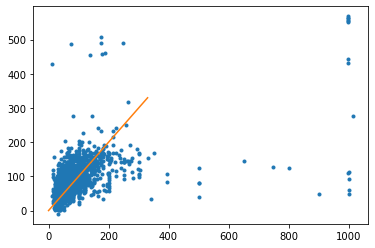

In [43]:
from matplotlib import pyplot as plt
# plot prediction and actual data

plt.plot(y_test, y_test_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 330, 100)
y = x
plt.plot(x, y)
plt.show()

